In [1]:
#experiment name and snapshot folder (used for model persistence)
experiment_setup_name = "tutorial.gym.atari.KungFuMaster-v0.cnn"
snapshot_path = "."


#gym game title
GAME_TITLE = 'KungFuMaster-v0'

#how many parallel game instances can your machine tolerate
N_PARALLEL_GAMES = 10


#how long is one replay session from a batch

#since we have window-like memory (no recurrent layers), we can use relatively small session weights
replay_seq_len = 25

In [2]:
#this is my machine-specific config. replace if are not me.

#theano device selection
%env THEANO_FLAGS='device=gpu2'


#snapshot path - where neural network snapshots are saved during the main training loop
!mkdir ./agentnet_snapshots/
snapshot_path = "./agentnet_snapshots/"


env: THEANO_FLAGS='device=gpu2'
mkdir: cannot create directory `./agentnet_snapshots/': File exists


# This tutorial is a showcase on how to use advanced AgentNet techniques 


# [new]

* The notebook is mostly based on "Playing atari with Deep Reinforcement Learning (OpenAI Gym)" example
 * All changes against that example will be marked with #[new] sign, like one above
* We use a recurrent memory layer, implemented via Gated Recurrent Unit
* We use advantage actor-critic method to train agent (using policy + state values instead of q-values)
* We train agent to hurt humans in KungFu master game
* We also use a bit heavier a network to process inputs (~convolutional from basic example)
  * If you have no GPU and want agent to train faster than human child, replace it with what worked in basic example

## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym
  
  
### Installing it
 * If nothing changed on their side, to run this, you bacically need to follow their install instructions - 
 
```
git clone https://github.com/openai/gym.git
cd gym
pip install -e .[all]
```

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports

import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


Using gpu device 2: Tesla K40m (CNMeM is disabled, CuDNN 4004)


In [4]:
%load_ext autoreload
%autoreload 2

# Experiment setup
* Here we basically just load the game

[2016-05-04 10:19:08,974] Making new env: KungFuMaster-v0


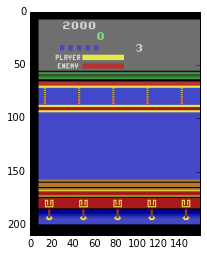

In [5]:
import gym
atari = gym.make(GAME_TITLE)
atari.reset()
plt.imshow(atari.render('rgb_array'))

### Game Parameters
* observation dimensions, actions, etc

In [6]:
n_actions = atari.action_space.n
observation_shape = (None,)+atari.observation_space.shape
action_names = atari.get_action_meanings()
print action_names

['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


In [7]:
del atari

# agent setup step by step
* An agent implementation may contain these parts:
 * Observation(s)
   * InputLayers where observed game states (here - images) are sent at each tick 
 * Memory layer(s)
   * A dictionary that maps "New memory layers" to "prev memory layers"
 * Policy layer (e.g. Q-values or probabilities)
   * in this case, a lasagne dense layer based on observation layer
 * Resolver - acton picker layer
   * chooses what action to take given Q-values
   * in this case, the resolver has epsilon-greedy policy
  




##### Agent observations

* Here you define where observations (game images) appear in the network
* You can use any lasagne architecture you want. We provide several examples

In [8]:
import lasagne

from lasagne.layers import InputLayer,DropoutLayer,DenseLayer, ExpressionLayer, Conv2DLayer,MaxPool2DLayer
from lasagne.layers import flatten, dimshuffle

In [9]:


#image observation
observation_layer = lasagne.layers.InputLayer(observation_shape,
                                                    name="images input")

observation_reshape = lasagne.layers.dimshuffle(observation_layer,(0,3,1,2))



# [ part where heavy convolutional network is defined]
#if you have to GPU, consider something lighter

#conv
cnn = Conv2DLayer(observation_reshape, num_filters=32,filter_size=(5,5),name='conv0')
cnn = Conv2DLayer(cnn, num_filters=32,filter_size=(5,5),name='conv1')
cnn = MaxPool2DLayer(cnn,(5,5))

#dense with dropout    
dnn = DenseLayer(cnn,num_units=500,name='dense0')
dnn = DropoutLayer(dnn,name = "dropout", p=0.05) #will get deterministic during evaluation
dnn = DenseLayer(dnn,num_units=300,name='dense1')

# [end of that part]

inp_nn = dnn

  
### Agent memory states
 * Here you can define arbitrary transitions between "previous state" variables and their next states
 * The rules are
   * previous states must be input layers
   * next states must have same shape as previous ones
   * otherwise it can be any lasagne network
   * AgentNet.memory has several useful layers
   
 * During training and evaluation, your states will be updated recurrently
   * next state at t=1 is given as previous state to t=2
 
 * Finally, you have to define a dictionary mapping new state -> previous state


Atari game environments are known to have __flickering__ effect where some sprites are shown only on odd frames and others on even ones - that was used to optimize performance at the time.

To compensate for this, we shall use the memory layer called __WindowAugmentation__ which basically maintains a K previous time steps of what it is fed with.


# [new]
We shall also use a GRUMemoryLayer to represent agent's recurrent memory state. This state is updated on every turn given window state.
Not that this is __not the same__ as `lasagne.layers.GRULayer` as GRUMemoryLayer only does a single time tick (lasagne version iterates over the whole sequence).



In [10]:

#memory
#using simple window-based memory that stores several states
#the SpaceInvaders environment does not need any more as it is almost fully-observed
from agentnet.memory import WindowAugmentation, GRUMemoryLayer


#our window
window_size = 3
prev_window = InputLayer((None,window_size,inp_nn.output_shape[1]),
                                        name = "previous window state")

window = WindowAugmentation(inp_nn,prev_window,name = "new window state")



# first (and so far only) GRU layer

gru0_size = 256

prev_gru0 = InputLayer((None,gru0_size),name="previous GRU0 state")

#neuron-wise maxima of window frames as an input to the GRU
window_max = ExpressionLayer(window,function=lambda v: v.max(axis=1), 
                             output_shape=inp_nn.output_shape,
                             name = 'window_max')


window_max = lasagne.layers.FeaturePoolLayer(window,window_size)

gru0 = GRUMemoryLayer(gru0_size,
                      observation_input = window_max,
                      prev_state_input = prev_gru0,
                      name="gru0"
                  )



#a dictionary that maps next agent memory states to previous ones
from collections import OrderedDict
memory_dict = OrderedDict([(window,prev_window),
                           (gru0,prev_gru0)])



##### Agent policy and action picking


# [new]

* Since we are using Actor-Critic method, we need to predict 2 values:
  * State value - basicly a Q-value of best action in a state
  * Agent policy - probabilities of taking actions
  

* To pick actions, we use a probablistic resolver
  * That one picks actions with given probabilities
  * We use a laplacian smoothing to pick actions in training (to bolster exploration) 
  * The resolver output is considered agent's next action and sent into the environment

In [11]:
#State values
state_value_layer = DenseLayer(gru0,
                               num_units = 1,
                               nonlinearity = lasagne.nonlinearities.linear,
                               name = "Vpredicted")


#a2c probabilities


policy_layer_pre_softmax = DenseLayer(gru0,
                                     num_units = n_actions,
                                     nonlinearity= None,
                                     name="policy_original")


from lasagne.layers import NonlinearityLayer
policy_layer = NonlinearityLayer(policy_layer_pre_softmax,
                                 lasagne.nonlinearities.softmax)


#actual action probablilities
epsilon = theano.shared(np.float32(0.1),"epsilon")


#add laplacian smoothing
smooth_policy_layer = NonlinearityLayer(
    policy_layer_pre_softmax,
    lambda v: lasagne.nonlinearities.softmax(v*(1.-epsilon) + epsilon/n_actions)
)





#resolver

from agentnet.resolver import ProbablisticResolver


resolver = ProbablisticResolver(smooth_policy_layer,assume_normalized=True,name="resolver")



##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

# [new]
* Note that we can have any (incl. none) number of agent policy variables,
* so you can use that to track any layer output
* It is also possible to have multiple observations and actions, but that's not aplicable to Atari environment

In [12]:
from agentnet.agent import Agent


#all together
agent = Agent(observation_layer,
              memory_dict,
              [policy_layer,state_value_layer],
              resolver)


In [13]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params((resolver,state_value_layer),trainable=True)
weights

[conv0.W,
 conv0.b,
 conv1.W,
 conv1.b,
 dense0.W,
 dense0.b,
 dense1.W,
 dense1.b,
 gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update,
 policy_original.W,
 policy_original.b,
 Vpredicted.W,
 Vpredicted.b]

# Agent step function
* Compute action and next state given observation and prev state
* The code was written in a generic way and did not undergo any changes since previous turorial

In [14]:
applier_observation = T.tensor4("input image",dtype=floatX)


# inputs to all agent memory states (usng lasagne defaults, may use any theano inputs)
applier_memories = OrderedDict([ (new_st,prev_st.input_var)
                                for new_st, prev_st in agent.state_variables.items()
                               ])


res =agent.get_agent_reaction(applier_memories,
                              applier_observation,
                              deterministic = True #disable dropout here. Only enable in experience replay
                             )


applier_actions,applier_new_states,applier_policy = res

applier_fun = theano.function([applier_observation]+applier_memories.values(),
        applier_actions+applier_new_states)


In [15]:
#a nice pythonic interface
def step(observation, prev_memories = 'zeros',batch_size = N_PARALLEL_GAMES):
    """ returns actions and new states given observation and prev state
    Prev state in default setup should be [prev window,]"""
    #default to zeros
    if prev_memories == 'zeros':
        prev_memories = [np.zeros((batch_size,)+tuple(mem.output_shape[1:]),
                                  dtype=floatX) 
                         for mem in agent.state_variables]
    
    res = applier_fun(np.array(observation),*prev_memories)
    action = res[0]
    memories = res[1:]
    return action,memories

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* We define a small container that stores
 * game emulators
 * last agent observations
 * agent memories at last time tick
* This allows us to instantly continue a session from where it stopped



* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf

In [16]:
#A whole lot of space invaders

class GamePool:
    def __init__(self,game_title,n_games):
        """
        A pool that stores several
           - game states (gym environment)
           - prev_observations - last agent observations
           - prev memory states - last agent hidden states
           
       """
        
        
        self.ataries = [gym.make(game_title) for i in range(n_games)]

        self.prev_observations = [atari.reset() for atari in self.ataries]
    
        self.prev_memory_states = 'zeros'

pool = GamePool(GAME_TITLE, N_PARALLEL_GAMES)


[2016-05-04 10:19:11,351] Making new env: KungFuMaster-v0
[2016-05-04 10:19:11,389] Making new env: KungFuMaster-v0
[2016-05-04 10:19:11,427] Making new env: KungFuMaster-v0
[2016-05-04 10:19:11,464] Making new env: KungFuMaster-v0
[2016-05-04 10:19:11,503] Making new env: KungFuMaster-v0
[2016-05-04 10:19:11,543] Making new env: KungFuMaster-v0
[2016-05-04 10:19:11,582] Making new env: KungFuMaster-v0
[2016-05-04 10:19:11,620] Making new env: KungFuMaster-v0
[2016-05-04 10:19:11,658] Making new env: KungFuMaster-v0
[2016-05-04 10:19:11,695] Making new env: KungFuMaster-v0


In [17]:
# a function that creates and records environment interaction sessions
def interact(pool,n_steps = 100,verbose=False):
    """generate interaction sessions with ataries (openAI gym atari environments)
    Sessions will have length n_steps. 
    Each time one of games is finished, it is immediately getting reset"""
    history_log = []
        
    prev_observations = pool.prev_observations 
    
    prev_memory_states = pool.prev_memory_states
    
    
    
    for i in range(n_steps):
        
        actions,new_memory_states = step(prev_observations,prev_memory_states)

        
        new_observations, cur_rewards, is_done, infos = \
            zip(*map(
                     lambda atari, action: atari.step(action), 
                     pool.ataries,actions))
            
        new_observations = np.array(new_observations)
        
        for i in range(len(pool.ataries)):
            if is_done[i]:
                new_observations[i] = pool.ataries[i].reset()
                
                for m_i in range(len(new_memory_states)):
                    new_memory_states[m_i][i] = 0
                    
                if verbose:
                    print "atari",i,"reloaded"
        
        
        #append observation -> action -> reward tuple
        history_log.append((prev_observations,actions,cur_rewards,new_memory_states,is_done,infos))
        
        prev_observations = new_observations
        prev_memory_states = new_memory_states
                
    pool.prev_memory_states = prev_memory_states
    pool.prev_observations = prev_observations
    
    return zip(*history_log)
    

In [18]:
%%time
observation_log,action_log,reward_log,_,_,_  = interact(pool,50)


print np.array(reward_log)[:10].T
print np.array(action_names)[np.array(action_log)[:3,:5]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[['LEFTFIRE' 'RIGHT' 'NOOP' 'UPLEFTFIRE' 'DOWN']
 ['RIGHT' 'RIGHTFIRE' 'DOWN' 'RIGHTFIRE' 'UP']
 ['DOWNRIGHT' 'DOWN' 'UPLEFTFIRE' 'DOWNRIGHTFIRE' 'DOWNLEFTFIRE']]
CPU times: user 1.67 s, sys: 368 ms, total: 2.04 s
Wall time: 2.03 s


# experience replay pool

Since our network exists in a theano graph and OpenAI gym doesn't, we shall train out network via experience replay.

To do that in AgentNet, one can use a SessionPoolEnvironment.

It's simple: you record new sessions using `interact(...)`, and than immediately train on them.

1. Interact with Atari, get play sessions
2. Store them into session environment
3. Train on them
4. Repeat


In [19]:
#Create an environment with all default parameters
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations = observation_layer,
                             actions=resolver,
                             agent_memories=[])

In [20]:
def update_pool(env, pool,n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    
    observation_log,action_log,reward_log,_,is_done_log,_= interact(pool,n_steps=n_steps)
    
    
    #tensor dimensions
    
    # [batch_i, time_i, width, height, rgb]
    observation_tensor = np.array(observation_log).swapaxes(0,1)
    
    # [batch_i,time_i]
    action_tensor = np.array(action_log).swapaxes(0,1)
    
    # [batch_i, time_i]
    reward_tensor = np.array(reward_log).swapaxes(0,1)

    # [batch_i, time_i]
    is_alive_tensor = 1- np.array(is_done_log,dtype = 'int8').swapaxes(0,1)
    
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,[])
    
    

In [21]:
#load first  sessions
update_pool(env,pool,replay_seq_len)

A more sophisticated way of training is to store a large pool of sessions and train on random batches of them. 
* Why that is expected to be better - http://www.nature.com/nature/journal/v518/n7540/full/nature14236.html
* Or less proprietary - https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

To do that, one might make use of
* ```env.load_sessions(...)``` - load new sessions
* ```env.get_session_updates(...)``` - does the same thing via theano updates (advanced)
* ```batch_env = env.sample_session_batch(batch_size, ...)``` - create an experience replay environment that contains batch_size random sessions from env (rerolled each time). Should be used in training instead of env.
* ```env.select_session_batch(indices)``` does the same thing deterministically.


# Interacting with environment
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (reinforcement learning objective)

### Training via experience replay

* We use agent we have created to replay environment interactions inside Theano
* to than train on the replayed sessions via theano gradient propagation
* this is essentially basic Lasagne code after the following cell

# [new]
* Note that we not unpack several variables (policy, values) instead of Q-values
* We than reshape V_seq from (batch, time, 1 unit) intp (batch_time)

In [22]:
#replay interaction sequences of length <= replay_seq_len

_,observation_seq,_,_,(policy_seq,V_seq) = agent.get_sessions(
    env,
    session_length=replay_seq_len,
    batch_size=env.batch_size,
)




#observation seq are the observation tensor we just loaded
#policy seq are agent action probabilities predicted within experience replay
# V_seq are agent state values

#The three "_"s are
#first - environment states - which is empty since we are using session pool as our environment
#second - a dictionary of all agent memory units (RNN, GRU, NTM) - empty as we use none of them
#last - "imagined" actions - actions agent would pick now if he was in that situation 
#                              - irrelevant since we are replaying and not actually playing the game now


#reshape V_seq from (batch, time, 1 unit) intp (batch_time)
V_seq = V_seq[:,:,0]


#the actions agent took in the original recorded game
action_seq = env.actions[0]

#get rewards for all actions
rewards_seq = env.rewards

#get indicator whether session is still active
is_alive_seq = env.is_alive


# Evaluating loss function

# [new]
* In this part we are using an n-step Advantage Actor-Critic (A2c)
* In this case, it's a 10-step a2c (see n_steps parameter)
* To use Q-learning or sarsa, you will have to predict Q-values instead of probabilities

* The basic interface is .get_elementwise_objective 
  * it returns loss function (here - actor-critic loss function)
  * $ log {\pi} \cdot (V_{percieved} - V_{predicted}) $
  * $\pi$ is agent policy, $V$'s are state values
  * Read more at http://www.arxiv.org/pdf/1602.01783v1.pdf
    
* If you want to do it the hard way instead, try .get_reference_state_values and compute errors on ya own
  

In [23]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import a2c_n_step

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.99),name = 'q_learning_gamma')


#IMPORTANT!
# If you are training on a game that has rewards far outside some [-5,+5]
# it is a good idea to downscale them to avoid divergence
scaled_reward_seq = rewards_seq
#For KungFuMaster, however, not scaling rewards is at least working


elwise_a2c_loss = a2c_n_step.get_elementwise_objective(policy_seq,
                                                       V_seq,
                                                       action_seq,
                                                       rewards_seq,
                                                       is_alive_seq,
                                                       n_steps=10, #using n-step on-policy actor-critic
                                                       gamma_or_gammas=gamma,)

#compute mean over "alive" fragments
a2c_loss = elwise_a2c_loss.sum() / is_alive_seq.sum()

### Regularization

# [new]
We regularize agent's policy with entropy
 * See here http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.54.3433&rep=rep1&type=pdf (ref by that article above)
 * Basically, we punish agent for being too certain on what to do

In [24]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-4



#regularize with entropy, - H(p(s,theta)). 

entropy_reg_elwise = - T.sum(policy_seq * T.log(policy_seq),axis=-1)

is_bad = T.or_(T.isinf(entropy_reg_elwise), T.isnan(entropy_reg_elwise))

entropy_reg_elwise = T.switch(is_bad, 0, entropy_reg_elwise)

reg_entropy =  T.sum(entropy_reg_elwise*is_alive_seq)/ is_alive_seq.sum() * 0.05


reg = reg_l2 + reg_entropy

In [25]:
loss = a2c_loss + reg

#### Compute weight updates

In [26]:

updates = lasagne.updates.adadelta(loss,
                                             weights,learning_rate=0.01)

#### Some auxilary evaluation metrics

In [27]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [28]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,a2c_loss,reg,mean_session_reward])

# Session visualization tools

__[warning, this thing basicly tries to track various Qvalues over time]__

__[but it's bulky and stupid, so don't try to understand it if it didn't come naturally]__


* this is a completely optional step of visualizing agent's sessions as chains of actions
* in this function, we display game image and than print strings following pattern
  * [action_name] ([predicted action proba]) -> reward | next iteration
  * each block represents agent's decision in a single time step following the shown game state 

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are probabilities of actions (agent policy
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]

At the beginning, agent knows nothing (Jon) and behaves randomly


# [new]
We just plug in probabilities instead of Qvalues

In [29]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        policy_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False,max_n_sessions = 3,update = True):
    
    pictures = [atari.render("rgb_array") for atari in pool.ataries[:max_n_sessions]]
    
    if update:
        #load these pics into environment
        update_pool(env,pool,replay_seq_len)
    
    
    printables = get_printables()
    
    
    for i in range(max_n_sessions):
        plt.imshow(pictures[i])
        plt.show()
            
        policy_log,actions_log,reward_log, is_alive_log = map(lambda v: np.array(v[i:i+1]), printables)
        

        print_sessions(policy_log,actions_log,reward_log,
                       is_alive_seq = is_alive_log,
                       action_names=action_names,
                       legend = True, #do not show legend since there's too many labeled objects
                      plot_policy = with_plots)

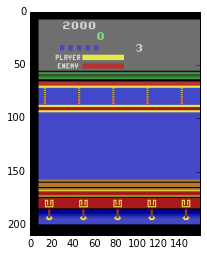

session # 0
 RIGHTFIRE(qv = 0.0714285746217) -> 0.0 |  RIGHT(qv = 0.0612516328692) -> 0.0 |  DOWNFIRE(qv = 0.05630614236) -> 0.0 |  RIGHTFIRE(qv = 0.168155372143) -> 0.0 |  RIGHTFIRE(qv = 0.243132442236) -> 0.0 |  RIGHTFIRE(qv = 0.264483332634) -> 0.0 |  DOWNFIRE(qv = 0.0475092194974) -> 0.0 |  UPLEFTFIRE(qv = 0.0374280661345) -> 0.0 |  RIGHTFIRE(qv = 0.132207930088) -> 0.0 |  NOOP(qv = 0.00806427933276) -> 0.0 |  UPLEFTFIRE(qv = 0.0562305487692) -> 0.0 |  DOWNFIRE(qv = 0.0848957151175) -> 0.0 |  DOWN(qv = 0.161895498633) -> 0.0 |  DOWNLEFT(qv = 0.0606449060142) -> 0.0 |  RIGHTFIRE(qv = 0.163001090288) -> 0.0 |  LEFT(qv = 0.182256415486) -> 0.0 |  RIGHTFIRE(qv = 0.112870723009) -> 0.0 |  UP(qv = 0.021769637242) -> 0.0 |  DOWN(qv = 0.123253643513) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0652168542147) -> 0.0 |  DOWNLEFT(qv = 0.0288611799479) -> 0.0 |  DOWN(qv = 0.203599736094) -> 0.0 |  DOWN(qv = 0.120886400342) -> 0.0 |  RIGHT(qv = 0.0421741493046) -> 0.0 |  DOWNFIRE(qv = 0.199306130409) -> 0.0 

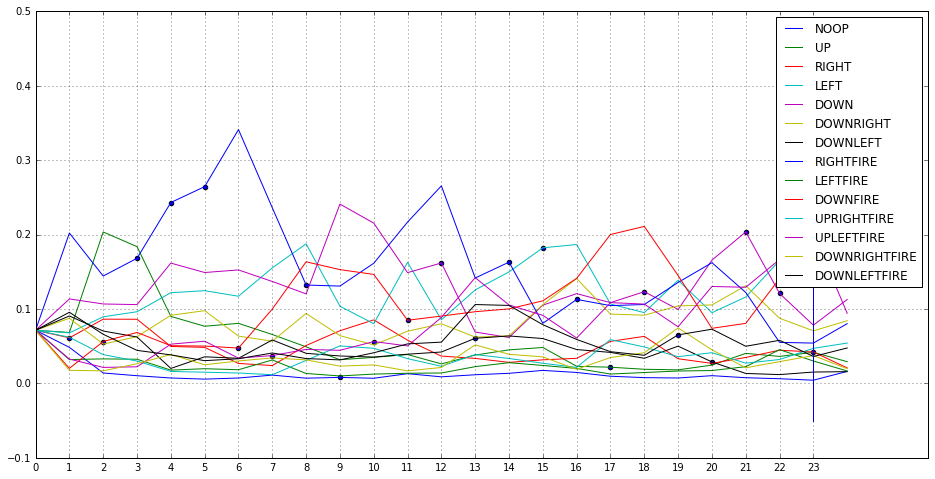

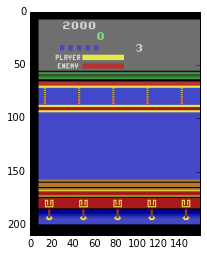

session # 0
 RIGHTFIRE(qv = 0.0714285746217) -> 0.0 |  DOWN(qv = 0.0600435473025) -> 0.0 |  RIGHT(qv = 0.0503042638302) -> 0.0 |  DOWN(qv = 0.121214881539) -> 0.0 |  RIGHTFIRE(qv = 0.216351985931) -> 0.0 |  RIGHTFIRE(qv = 0.161053180695) -> 0.0 |  DOWNFIRE(qv = 0.0832089707255) -> 0.0 |  DOWN(qv = 0.0975803732872) -> 0.0 |  UPRIGHTFIRE(qv = 0.0416102297604) -> 0.0 |  DOWNFIRE(qv = 0.101086035371) -> 0.0 |  DOWNFIRE(qv = 0.122697003186) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.0296068266034) -> 0.0 |  LEFT(qv = 0.164471372962) -> 0.0 |  RIGHTFIRE(qv = 0.128266781569) -> 0.0 |  DOWN(qv = 0.185665041208) -> 0.0 |  UP(qv = 0.0372193492949) -> 0.0 |  DOWNFIRE(qv = 0.0688601583242) -> 0.0 |  UP(qv = 0.0401966311038) -> 0.0 |  RIGHTFIRE(qv = 0.0912444964051) -> 0.0 |  RIGHTFIRE(qv = 0.107443802059) -> 0.0 |  UPRIGHTFIRE(qv = 0.0221162624657) -> 0.0 |  NOOP(qv = 0.0172183010727) -> 0.0 |  DOWNFIRE(qv = 0.0267174877226) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.0125246578828) -> 0.0 |  LEFTFIRE(qv = 0.0155100179836

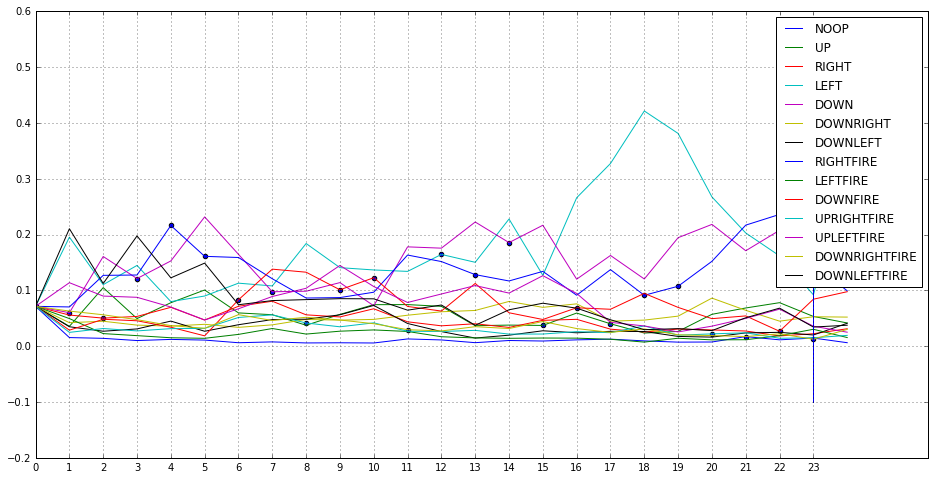

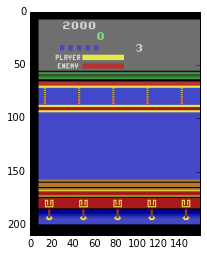

session # 0
 LEFT(qv = 0.0714285746217) -> 0.0 |  RIGHTFIRE(qv = 0.350761115551) -> 0.0 |  UPLEFTFIRE(qv = 0.056251052767) -> 0.0 |  RIGHTFIRE(qv = 0.286752462387) -> 0.0 |  DOWN(qv = 0.162649720907) -> 0.0 |  RIGHT(qv = 0.0878421962261) -> 0.0 |  LEFTFIRE(qv = 0.00589800998569) -> 0.0 |  DOWNRIGHT(qv = 0.105232603848) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.0398467630148) -> 0.0 |  LEFT(qv = 0.144552543759) -> 0.0 |  DOWN(qv = 0.223121091723) -> 0.0 |  DOWN(qv = 0.148619920015) -> 0.0 |  RIGHTFIRE(qv = 0.200135961175) -> 0.0 |  RIGHTFIRE(qv = 0.300182551146) -> 0.0 |  DOWN(qv = 0.155837401748) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0505338311195) -> 0.0 |  RIGHTFIRE(qv = 0.160901546478) -> 0.0 |  RIGHT(qv = 0.0488774292171) -> 0.0 |  DOWNRIGHT(qv = 0.149269089103) -> 0.0 |  RIGHT(qv = 0.0414220243692) -> 0.0 |  LEFTFIRE(qv = 0.010302211158) -> 0.0 |  RIGHTFIRE(qv = 0.210424661636) -> 0.0 |  RIGHTFIRE(qv = 0.204792439938) -> 0.0 |  DOWNLEFT(qv = 0.037859134376) -> 0.0 |  DOWNFIRE(qv = 0.161398127675) ->

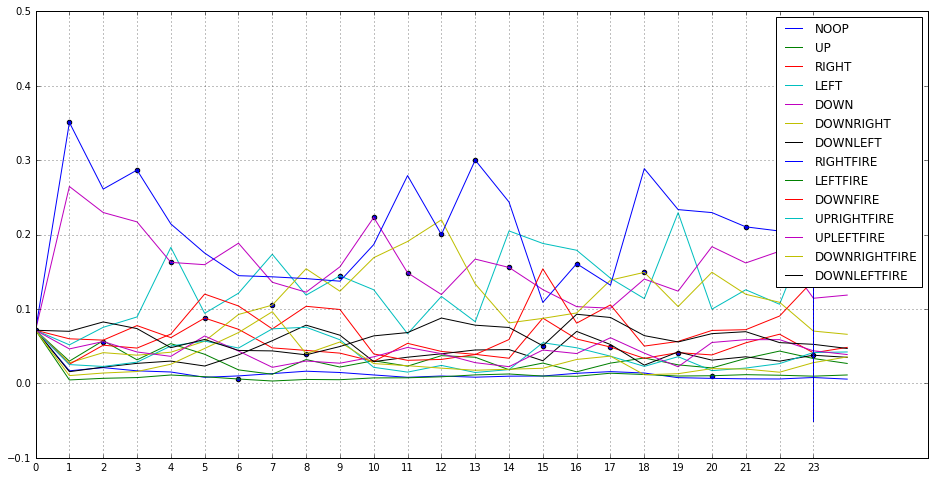

In [30]:
#visualize untrained network performance (which is mostly random)
display_sessions(with_plots=True)

# Training loop

In [31]:
#tools for model persistence (in progress now. Requires unique names)
from agentnet.utils.persistence import save,load
import os

In [32]:
from agentnet.display import Metrics
score_log = Metrics()

In [ ]:
#starting epoch
epoch_counter = 1
#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 50,loss 520.45179, epsilon 0.49109, rewards: ( e-greedy 2.00000, greedy 1.00000) 
rec 519.776 reg 0.676
epoch 100,loss 2.35375, epsilon 0.48236, rewards: ( e-greedy 1.80000, greedy 0.90000) 
rec 1.703 reg 0.651
epoch 150,loss 618.31503, epsilon 0.47379, rewards: ( e-greedy 3.62000, greedy 1.81000) 
rec 617.636 reg 0.679
epoch 200,loss 1.25264, epsilon 0.46540, rewards: ( e-greedy 3.25800, greedy 2.62900) 
rec 0.571 reg 0.681
epoch 250,loss 1813.50331, epsilon 0.45718, rewards: ( e-greedy 6.93220, greedy 2.36610) 
rec 1812.815 reg 0.688
epoch 300,loss 1.52969, epsilon 0.44911, rewards: ( e-greedy 6.23898, greedy 6.12949) 
rec 0.851 reg 0.679
epoch 350,loss 2.28623, epsilon 0.44121, rewards: ( e-greedy 5.61508, greedy 7.51654) 
rec 1.611 reg 0.675
epoch 400,loss 321.61336, epsilon 0.43346, rewards: ( e-greedy 7.05357, greedy 6.76489) 
rec 320.928 reg 0.685
epoch 450,loss 0.67675, epsilon 0.42587, rewards: ( e-greedy 6.34822, greedy 6.08840) 
rec -0.009 reg 0.685
epoch 500,loss 1.12

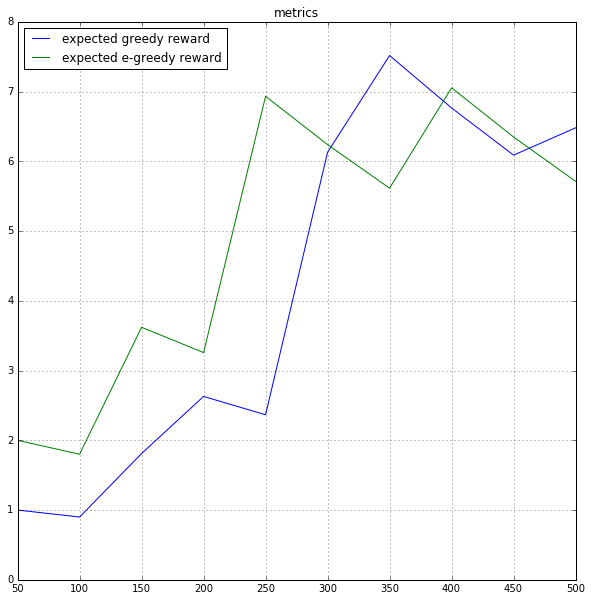

Random session examples


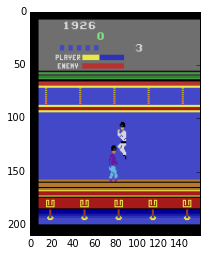

session # 0
 LEFTFIRE(qv = 0.0824266672134) -> 0.0 |  UP(qv = 0.102294236422) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0119980061427) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.0146748730913) -> 0.0 |  DOWNRIGHT(qv = 0.0643775090575) -> 0.0 |  DOWNLEFT(qv = 0.0280120950192) -> 0.0 |  UP(qv = 0.0695151910186) -> 0.0 |  DOWNRIGHT(qv = 0.143160909414) -> 0.0 |  UPLEFTFIRE(qv = 0.0887465178967) -> 0.0 |  UPRIGHTFIRE(qv = 0.141341298819) -> 0.0 |  UPLEFTFIRE(qv = 0.115849390626) -> 0.0 |  UP(qv = 0.0534188449383) -> 0.0 |  UPRIGHTFIRE(qv = 0.115288123488) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0149381309748) -> 0.0 |  DOWNFIRE(qv = 0.120766013861) -> 0.0 |  LEFT(qv = 0.0309538431466) -> 0.0 |  UP(qv = 0.0701846182346) -> 0.0 |  DOWNFIRE(qv = 0.0931464582682) -> 0.0 |  UPLEFTFIRE(qv = 0.130061686039) -> 0.0 |  UPLEFTFIRE(qv = 0.128263041377) -> 0.0 |  LEFTFIRE(qv = 0.0709229633212) -> 0.0 |  UPLEFTFIRE(qv = 0.15616184473) -> 0.0 |  DOWNRIGHT(qv = 0.244199886918) -> 0.0 |  UP(qv = 0.0484225265682) -> 0.0 |  UPRIGHTFIRE(qv =

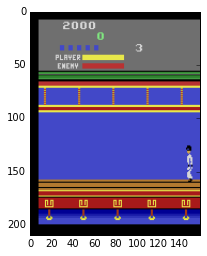

session # 0
 UPRIGHTFIRE(qv = 0.0735537186265) -> 0.0 |  UPRIGHTFIRE(qv = 0.0670593231916) -> 0.0 |  UPLEFTFIRE(qv = 0.286969542503) -> 0.0 |  LEFTFIRE(qv = 0.101439714432) -> 0.0 |  UPLEFTFIRE(qv = 0.150433793664) -> 0.0 |  UP(qv = 0.0596561804414) -> 0.0 |  DOWNRIGHT(qv = 0.155318528414) -> 0.0 |  DOWNRIGHT(qv = 0.139564737678) -> 0.0 |  DOWNRIGHT(qv = 0.134850114584) -> 0.0 |  RIGHT(qv = 0.0640088245273) -> 0.0 |  UP(qv = 0.109523259103) -> 0.0 |  DOWN(qv = 0.0505060851574) -> 0.0 |  UP(qv = 0.0621842928231) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.0148016363382) -> 0.0 |  UPLEFTFIRE(qv = 0.114509753883) -> 0.0 |  UP(qv = 0.110925801098) -> 0.0 |  DOWNLEFTFIRE(qv = 0.020010733977) -> 0.0 |  DOWN(qv = 0.0609620846808) -> 0.0 |  UPRIGHTFIRE(qv = 0.101931110024) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.0201395638287) -> 0.0 |  UPLEFTFIRE(qv = 0.213553547859) -> 0.0 |  UPLEFTFIRE(qv = 0.213767677546) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.0157533101737) -> 0.0 |  DOWNFIRE(qv = 0.185282573104) -> 0.0 |  DOWNLEFT(qv

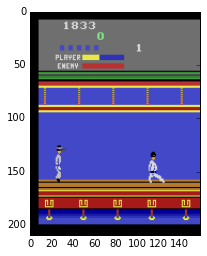

session # 0
 DOWNLEFTFIRE(qv = 0.0640779286623) -> 0.0 |  DOWNRIGHT(qv = 0.0861670970917) -> 0.0 |  UPLEFTFIRE(qv = 0.274315148592) -> 0.0 |  UPRIGHTFIRE(qv = 0.11255672574) -> 0.0 |  NOOP(qv = 0.0130596971139) -> 0.0 |  DOWNFIRE(qv = 0.112097986042) -> 0.0 |  LEFTFIRE(qv = 0.0586405768991) -> 0.0 |  LEFTFIRE(qv = 0.0646305903792) -> 0.0 |  LEFTFIRE(qv = 0.0503788739443) -> 0.0 |  UP(qv = 0.0871603116393) -> 0.0 |  DOWNRIGHT(qv = 0.120830401778) -> 0.0 |  RIGHT(qv = 0.0563281998038) -> 0.0 |  RIGHTFIRE(qv = 0.00982966460288) -> 0.0 |  DOWNRIGHT(qv = 0.0819062590599) -> 0.0 |  DOWNFIRE(qv = 0.0883412137628) -> 0.0 |  DOWNLEFT(qv = 0.0257052108645) -> 0.0 |  DOWNRIGHT(qv = 0.109686024487) -> 0.0 |  DOWNRIGHT(qv = 0.135996043682) -> 0.0 |  DOWN(qv = 0.0591330304742) -> 0.0 |  DOWNLEFT(qv = 0.0255064480007) -> 0.0 |  LEFTFIRE(qv = 0.059864949435) -> 0.0 |  UP(qv = 0.0972676277161) -> 0.0 |  DOWNLEFT(qv = 0.0132594229653) -> 0.0 |  NOOP(qv = 0.0148384952918) -> 0.0 |  LEFT(qv = 0.0224673282

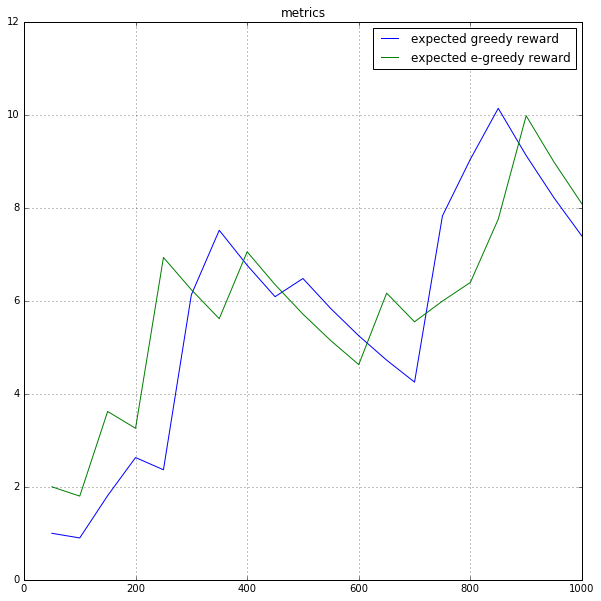

Random session examples


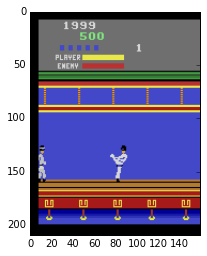

session # 0
 UP(qv = 0.103118017316) -> 0.0 |  LEFT(qv = 0.0961049571633) -> 0.0 |  DOWNFIRE(qv = 0.207472756505) -> 0.0 |  DOWNFIRE(qv = 0.198405072093) -> 0.0 |  DOWNLEFT(qv = 0.0309349149466) -> 0.0 |  DOWNRIGHT(qv = 0.138522535563) -> 0.0 |  DOWNFIRE(qv = 0.157167434692) -> 0.0 |  DOWNRIGHT(qv = 0.161304846406) -> 0.0 |  UPRIGHTFIRE(qv = 0.0525374636054) -> 0.0 |  UP(qv = 0.0323748141527) -> 0.0 |  DOWNRIGHT(qv = 0.185889869928) -> 0.0 |  RIGHTFIRE(qv = 0.0183943063021) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.00729912566021) -> 0.0 |  DOWNRIGHT(qv = 0.177238419652) -> 0.0 |  UPLEFTFIRE(qv = 0.0858721584082) -> 0.0 |  DOWNFIRE(qv = 0.142551749945) -> 0.0 |  DOWNLEFT(qv = 0.0348483920097) -> 0.0 |  UPRIGHTFIRE(qv = 0.0577037371695) -> 0.0 |  DOWNLEFT(qv = 0.0302057247609) -> 0.0 |  UPRIGHTFIRE(qv = 0.0506739541888) -> 0.0 |  NOOP(qv = 0.00910981651396) -> 0.0 |  DOWN(qv = 0.00416909717023) -> 0.0 |  UPRIGHTFIRE(qv = 0.0425316207111) -> 0.0 |  LEFT(qv = 0.124224223197) -> 0.0 |  DOWNRIGHT(qv =

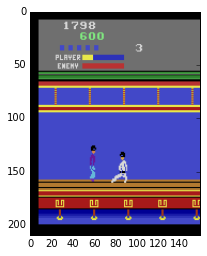

session # 0
 DOWNRIGHT(qv = 0.121193438768) -> 0.0 |  RIGHT(qv = 0.116298474371) -> 0.0 |  RIGHTFIRE(qv = 0.0245636962354) -> 0.0 |  DOWNRIGHT(qv = 0.119524009526) -> 0.0 |  LEFTFIRE(qv = 0.0989765077829) -> 0.0 |  UPRIGHTFIRE(qv = 0.0269662961364) -> 100.0 |  UP(qv = 0.0449178926647) -> 0.0 |  NOOP(qv = 0.0227861274034) -> 0.0 |  RIGHT(qv = 0.125287607312) -> 0.0 |  DOWNFIRE(qv = 0.102657578886) -> 0.0 |  RIGHT(qv = 0.0737014263868) -> 0.0 |  UP(qv = 0.0448662787676) -> 0.0 |  UPRIGHTFIRE(qv = 0.0437675192952) -> 0.0 |  UP(qv = 0.0388368554413) -> 0.0 |  UP(qv = 0.03684720397) -> 0.0 |  DOWNFIRE(qv = 0.201533034444) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0156477224082) -> 0.0 |  DOWNFIRE(qv = 0.204821407795) -> 0.0 |  UPLEFTFIRE(qv = 0.118601188064) -> 0.0 |  RIGHTFIRE(qv = 0.0173663143069) -> 0.0 |  RIGHT(qv = 0.130558937788) -> 0.0 |  DOWNFIRE(qv = 0.0887331962585) -> 0.0 |  RIGHT(qv = 0.128054350615) -> 0.0 |  UPLEFTFIRE(qv = 0.172808855772) -> 0.0 |  UPRIGHTFIRE(qv = 0.033690597862) -> 0.0

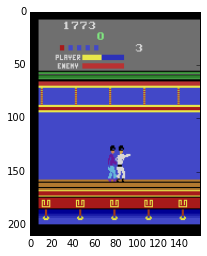

session # 0
 UP(qv = 0.090030297637) -> 0.0 |  DOWNFIRE(qv = 0.0911965817213) -> 0.0 |  DOWNFIRE(qv = 0.0967854857445) -> 0.0 |  DOWN(qv = 0.00308792176656) -> 0.0 |  UPRIGHTFIRE(qv = 0.0267508998513) -> 0.0 |  DOWNRIGHT(qv = 0.133335113525) -> 0.0 |  DOWNFIRE(qv = 0.128625527024) -> 0.0 |  NOOP(qv = 0.00924730114639) -> 0.0 |  LEFTFIRE(qv = 0.174189403653) -> 0.0 |  DOWNRIGHT(qv = 0.168514400721) -> 0.0 |  DOWNFIRE(qv = 0.166370555758) -> 0.0 |  LEFT(qv = 0.100746244192) -> 0.0 |  RIGHTFIRE(qv = 0.014093878679) -> 0.0 |  RIGHT(qv = 0.200150609016) -> 0.0 |  DOWNRIGHT(qv = 0.0965672656894) -> 0.0 |  LEFTFIRE(qv = 0.119453065097) -> 0.0 |  DOWNRIGHT(qv = 0.142633408308) -> 0.0 |  DOWNFIRE(qv = 0.146699592471) -> 0.0 |  RIGHT(qv = 0.151369795203) -> 0.0 |  RIGHT(qv = 0.0981844812632) -> 0.0 |  NOOP(qv = 0.0185539238155) -> 0.0 |  LEFT(qv = 0.0577955842018) -> 0.0 |  DOWNFIRE(qv = 0.158024951816) -> 0.0 |  DOWNLEFT(qv = 0.0398782044649) -> 0.0 |  RIGHTFIRE(qv = 0.024025939405) -> 0.0 | re

In [ ]:
n_epochs = 10000
batch_size= 10

for i in range(n_epochs):    
    
    
    #train
    update_pool(env,pool,replay_seq_len)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/2500.)
        epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        epsilon.set_value(0)
        update_pool(env,pool,replay_seq_len)

        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        epsilon.set_value(np.float32(current_epsilon))
        update_pool(env,pool,replay_seq_len)

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

    if epoch_counter %500 ==0:
        print "Learning curves:"
        score_log.plot()


        print "Random session examples"
        display_sessions(with_plots=False)
    
    #save snapshot
    if epoch_counter %1000 ==0:
        snap_name = "{}.epoch{}.pcl".format(os.path.join(snapshot_path,experiment_setup_name), epoch_counter)
        save(resolver,snap_name)
        print "saved", snap_name

        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials
 * we took epoch 7k for final submission
 * done via `load(resolver,"./agentnet_snapshots/{your experiment_setup_name}.epoch7000.pcl")`

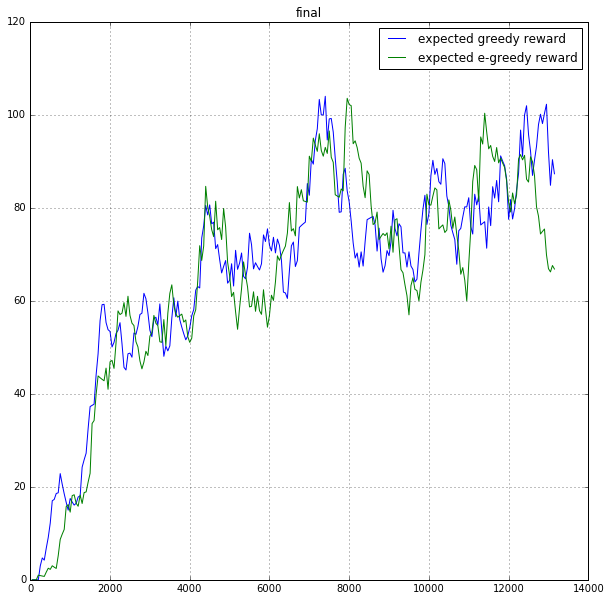

In [35]:
score_log.plot("final")

Random session examples


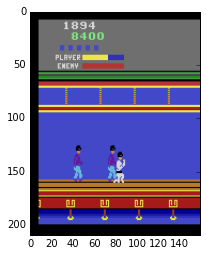

session # 0
 DOWN(qv = 0.209978818893) -> 0.0 |  UPLEFTFIRE(qv = 0.302690476179) -> 0.0 |  UPLEFTFIRE(qv = 0.302690476179) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235172405839) -> 0.0 |  DOWN(qv = 0.256403476) -> 0.0 |  DOWN(qv = 0.256403476) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235172405839) -> 0.0 |  DOWN(qv = 0.256403476) -> 200.0 |  DOWNRIGHT(qv = 0.0358445718884) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235172405839) -> 0.0 |  DOWNLEFTFIRE(qv = 0.3447496593) -> 0.0 |  DOWN(qv = 0.256403476) -> 0.0 |  UPLEFTFIRE(qv = 0.302690476179) -> 0.0 |  RIGHT(qv = 0.0438031703234) -> 0.0 |  UPLEFTFIRE(qv = 0.302690476179) -> 0.0 |  DOWN(qv = 0.256403476) -> 0.0 |  DOWN(qv = 0.256403476) -> 0.0 |  UPLEFTFIRE(qv = 0.302690476179) -> 0.0 |  LEFT(qv = 0.0747688040137) -> 0.0 |  DOWN(qv = 0.256403476) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235172405839) -> 0.0 |  UPLEFTFIRE(qv = 0.302690476179) -> 0.0 |  UPLEFTFIRE(qv = 0.302690476179) -> 0.0 |  RIGHT(qv = 0.0438031703234) -> 0.0 |  UPLEFTFIRE(qv = 0.302690476179) -> 0.0 | reached ma

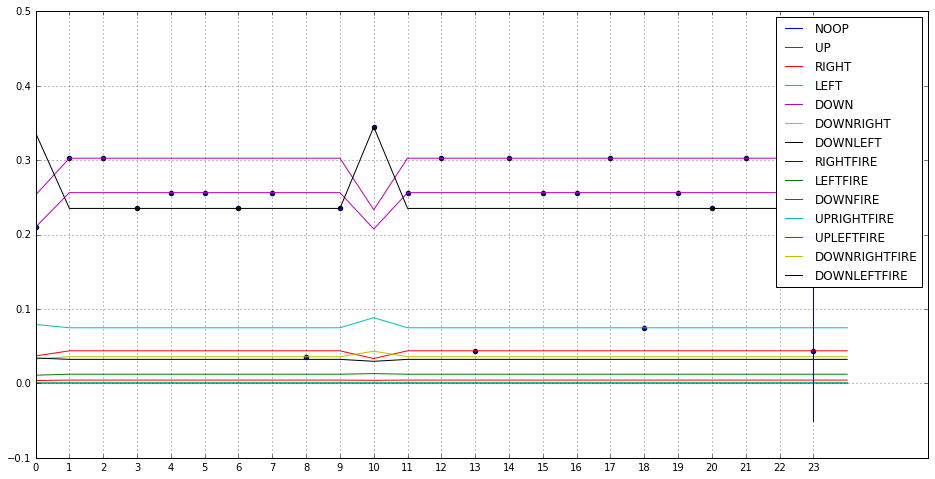

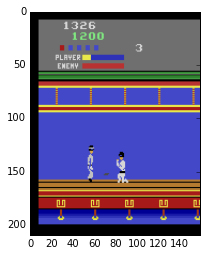

session # 0
 LEFT(qv = 0.0794909521937) -> 0.0 |  DOWNLEFT(qv = 0.0323165617883) -> 0.0 |  UPLEFTFIRE(qv = 0.302703469992) -> 0.0 |  DOWNRIGHT(qv = 0.035844437778) -> 0.0 |  DOWN(qv = 0.256388962269) -> 0.0 |  DOWNRIGHT(qv = 0.035844437778) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235168173909) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235168173909) -> 0.0 |  DOWNLEFT(qv = 0.0323165617883) -> 0.0 |  UPLEFTFIRE(qv = 0.302703469992) -> 0.0 |  UPLEFTFIRE(qv = 0.302703469992) -> 0.0 |  UPLEFTFIRE(qv = 0.302703469992) -> 0.0 |  UPLEFTFIRE(qv = 0.302703469992) -> 0.0 |  DOWN(qv = 0.256388962269) -> 0.0 |  LEFT(qv = 0.0747636556625) -> 0.0 |  DOWNRIGHT(qv = 0.035844437778) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235168173909) -> 0.0 |  DOWN(qv = 0.256388962269) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235168173909) -> 0.0 |  UPLEFTFIRE(qv = 0.302703469992) -> 0.0 |  LEFT(qv = 0.0747636556625) -> 0.0 |  RIGHT(qv = 0.0438134670258) -> 0.0 |  UPLEFTFIRE(qv = 0.302703469992) -> 0.0 |  DOWN(qv = 0.256388962269) -> 0.0 |  UPLEFTFIRE(qv = 0.3

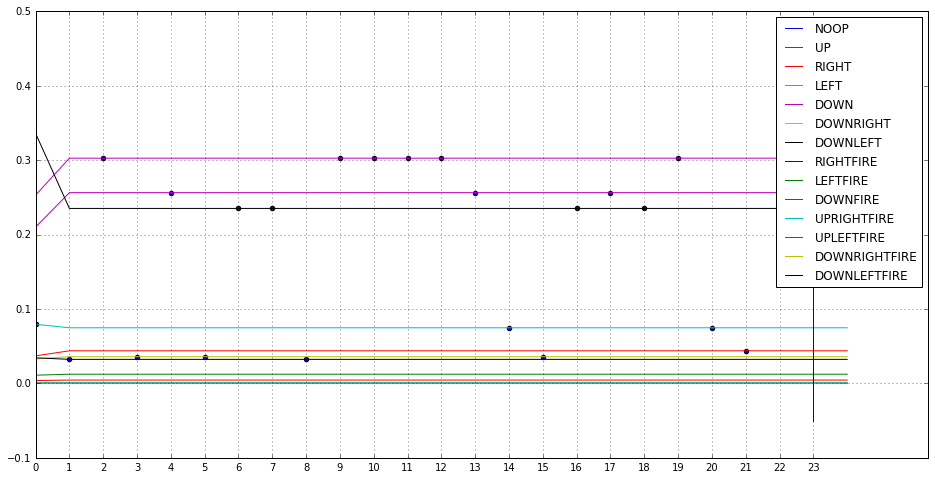

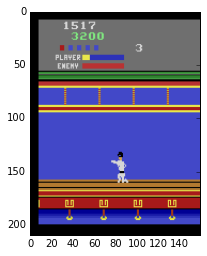

session # 0
 DOWNLEFTFIRE(qv = 0.33404481411) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235171437263) -> 0.0 |  DOWN(qv = 0.255167156458) -> 0.0 |  DOWN(qv = 0.255167156458) -> 0.0 |  LEFT(qv = 0.0747660771012) -> 0.0 |  DOWN(qv = 0.25640052557) -> 0.0 |  UPLEFTFIRE(qv = 0.302700221539) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235171437263) -> 0.0 |  DOWN(qv = 0.25640052557) -> 0.0 |  UPLEFTFIRE(qv = 0.302700221539) -> 0.0 |  UPLEFTFIRE(qv = 0.302700221539) -> 0.0 |  UPLEFTFIRE(qv = 0.302700221539) -> 0.0 |  DOWN(qv = 0.25640052557) -> 0.0 |  RIGHT(qv = 0.0438035652041) -> 0.0 |  DOWN(qv = 0.255167156458) -> 0.0 |  DOWN(qv = 0.25640052557) -> 0.0 |  UPLEFTFIRE(qv = 0.302700221539) -> 0.0 |  DOWN(qv = 0.25640052557) -> 0.0 |  UPLEFTFIRE(qv = 0.302700221539) -> 0.0 |  DOWN(qv = 0.25640052557) -> 0.0 |  DOWNRIGHT(qv = 0.0358428172767) -> 0.0 |  UPLEFTFIRE(qv = 0.302700221539) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235171437263) -> 0.0 |  DOWN(qv = 0.25640052557) -> 0.0 |  DOWNRIGHT(qv = 0.0358428172767) -> 0.0 | reached

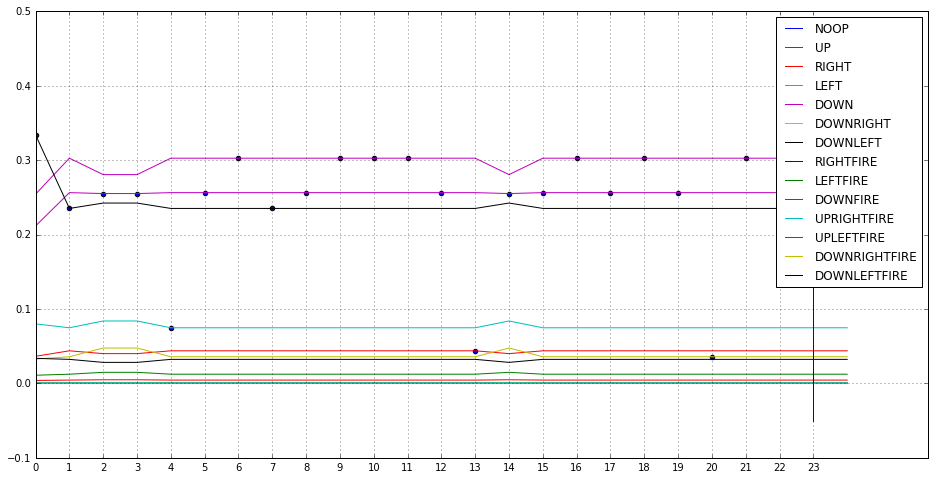

In [39]:
print "Random session examples"
display_sessions(with_plots=True)


# Submission

In [40]:
epsilon.set_value(0)

In [46]:

save_path = '/tmp/AgentNet-simplenet-kungfu-v0-Recording0'

subm_env = gym.make(GAME_TITLE)

#starting monitor. This setup does not write videos
subm_env.monitor.start(save_path,lambda i: False,force=True)

#this setup does
#subm_env.monitor.start(save_path,force=True)


for i_episode in xrange(200):
    
    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = [np.zeros((1,)+tuple(mem.output_shape[1:]),dtype=floatX) 
                         for mem in agent.state_variables]
    
    
    t = 0
    while True:

        action,new_memories = step([observation],prev_memories)
        observation, reward, done, info = subm_env.step(action)
        
        prev_memories = new_memories
        if done:
            print "Episode finished after {} timesteps".format(t+1)
            break
        t+=1

subm_env.monitor.close()

[2016-05-02 14:52:38,054] Making new env: KungFuMaster-v0
[2016-05-02 14:52:38,094] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 2238 timesteps
Episode finished after 3075 timesteps
Episode finished after 2156 timesteps
Episode finished after 2328 timesteps
Episode finished after 2766 timesteps
Episode finished after 2876 timesteps
Episode finished after 1954 timesteps
Episode finished after 1986 timesteps
Episode finished after 1915 timesteps
Episode finished after 2205 timesteps
Episode finished after 2011 timesteps
Episode finished after 2749 timesteps
Episode finished after 2140 timesteps
Episode finished after 1900 timesteps
Episode finished after 3176 timesteps
Episode finished after 2900 timesteps
Episode finished after 4663 timesteps
Episode finished after 1699 timesteps
Episode finished after 2727 timesteps
Episode finished after 2098 timesteps
Episode finished after 1854 timesteps
Episode finished after 1505 timesteps
Episode finished after 1850 timesteps
Episode finished after 1930 timesteps
Episode finished after 2239 timesteps
Episode finished after 2853 timesteps
Episode fini

[2016-05-02 16:01:52,376] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/AgentNet-simplenet-kungfu-v0-Recording0')


Episode finished after 2168 timesteps


In [47]:
gym.monitoring._monitors.clear()

In [ ]:

gym.upload(save_path,
           
           #this notebook
           writeup=<url to my gist>, 
           
           #your api key
           api_key=<my_own_api_key>)
